# infer cosmology

In [1]:
import os
import h5py 
import numpy as np

In [2]:
import astropy.table as aTable

In [3]:
import torch
from sbi import utils as Ut
from sbi import inference as Inference

In [4]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

# load $q_\phi(\theta_g\,|\,X), q_\phi(\theta_g\,|\,\theta_{\rm cosmo})$

In [6]:
dat_dir = '/tigress/chhahn/cgpop/'
qphi_thetag_X = torch.load(os.path.join(dat_dir, 'qphi.thetag_X.pt'))
qphi_thetag_thetacosmo = torch.load(os.path.join(dat_dir, 'qphi.thetag_thetacosmo.pt'))

In [16]:
qphi_thetag_thetacosmo.set_default_x([0.3, 0.8, 1., 1., 1., 1.])

DirectPosterior sampler for potential_fn=<PosteriorBasedPotential>

# compute posterior
$$p(\theta_{\rm cosmo}\,|\,\{X_i\}) = p(\theta_{\rm cosmo}) \prod_i^{N_g} \frac{1}{S_i} \sum\limits_j^{S_i} \frac{p(\theta_g\,|\,\theta_{\rm cosmo})}{p(\theta_g)}$$

In [7]:
X_test = np.array([-17.957348, -18.400158, -18.55086 , -18.714317, 0.022, 0.022, 0.022, 0.022])

In [8]:
thetag_prime = qphi_thetag_X.sample((10000,), 
                                    x=torch.as_tensor(X_test.astype(np.float32)).to(device), 
                                    show_progress_bars=True)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [58]:
def log_posterior_i(post_i, theta): 
    ''' calculate loss
    
    \sum_i^Ng w_i * \log \sum_j^Ns qphi(\theta_ij)
    
    '''
    return np.float(torch.logsumexp(qphi_thetag_thetacosmo.log_prob(torch.tensor(post_i).to(device),
                                x=torch.tensor(theta).to(device)), 0).cpu())

In [76]:
Oms = []
s8s = [] 
logposts = [] 
for om in np.linspace(0.1, 0.5, 20): 
    for s8 in np.linspace(0.4, 1.2, 20):
        Oms.append(om)
        s8s.append(s8)
        logposts.append(log_posterior_i(thetag_prime, [om, s8, 1., 1., 1., 1.]))

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


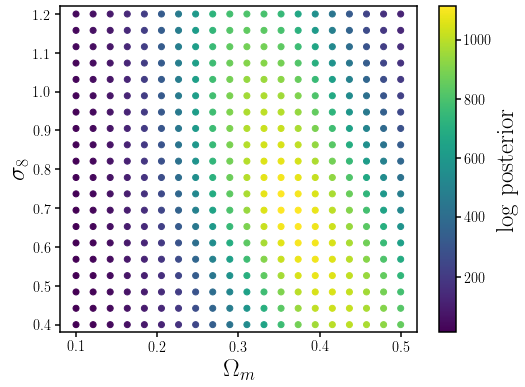

In [89]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
scat = sub.scatter(np.array(Oms), np.array(s8s), c=np.exp(np.array(logposts)))
sub.set_xlabel('$\Omega_m$', fontsize=25)
sub.set_xlim(0.08, 0.52)
sub.set_ylabel('$\sigma_8$', fontsize=25)
sub.set_ylim(0.38, 1.22)
cb = plt.colorbar(scat)
cb.set_label('log posterior', fontsize=25)